ColDefs(
    name = 'TIME'; format = '1D'; unit = 's'
    name = 'COUNTS'; format = '4I'; unit = 'count'; bzero = 32768
)
[(7.14789227e+08, [   141,     73,     41,     52])
 (7.14789227e+08, [   125,     59,     51,     53])
 (7.14789227e+08, [    88,     96,     55,     54]) ...
 (7.14790704e+08, [    84,     79,     57,     64])
 (7.14790704e+08, [    70,     67,     56,     45])
 (7.14790704e+08, [    66,     72,     67,     48])]


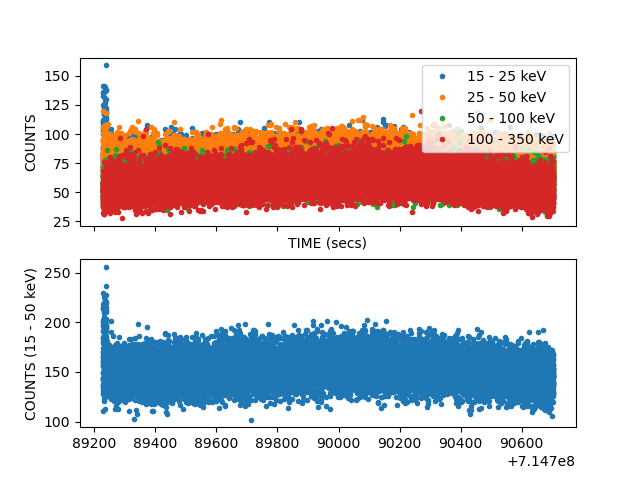

In [6]:
# setup
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

binedges = np.array([15,25,50,100,350])
hdul = fits.open('~/data/mirror/swift/00096727251/bat/rate/sw00096727251brtms.lc')
plot_data = hdul[1].data
print(plot_data.columns)
print(plot_data)


# creating the figure
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True)

# plot 1: split by energy bands
for i in range(4):
    axes[0].plot(plot_data['TIME'], plot_data['COUNTS'][:, i], ".", label = f"{binedges[i]} - {binedges[i+1]} keV")
axes[0].legend()
axes[0].set(ylabel = "COUNTS", xlabel = "TIME (secs)")
y_points = np.array(plot_data['COUNTS'])

# # plot 2: counts vs. time for 15-50 keV energy bands
counts = np.sum(plot_data['COUNTS'][:,0:2], axis=-1)
axes[1].plot(plot_data['TIME'], counts, ".")
axes[1].set(ylabel = f"COUNTS ({binedges[0]} - {binedges[2]} keV)")

# plot 3: rate vs. time for 15-50 keV energy bands
#dt = np.median(np.diff(plot_data['TIME']))    # size of the timebin
#rate = np.sum(plot_data['COUNTS'][:,0:2], axis=-1) / dt
#axes[1].plot(plot_data['TIME'], rate, ".")
#axes[1].set(ylabel = f"RATE (counts {binedges[0]} - {binedges[2]} keV) / s")

%matplotlib ipympl
plt.show()


In [7]:
import batanalysis as ba
import swiftbat
import swifttools
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from scipy import fftpack
from pathlib import Path
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.modeling import models
from astropy.modeling.fitting import fitter_to_model_params
from numpy import mean
from numpy import arange
from scipy.fftpack import fft, rfft
import scipy.fft
from scipy.signal import find_peaks, welch
from scipy.optimize import curve_fit
import datetime
import os
import stingray
from stingray import Lightcurve, DynamicalPowerspectrum, AveragedPowerspectrum
from stingray.modeling import PSDLogLikelihood, PSDPosterior, PSDParEst
from lmfit import Parameters, Minimizer
from lmfit.models import LorentzianModel, ConstantModel
sourcename = "Swift J1727.8-1613"
source = swiftbat.source(sourcename)    # Can look up positions from Simbad, and can calculate exposure for a given pointing
topdir = Path("~/ICR_Project").expanduser()
datafilelistfile = topdir.joinpath("datafiles.txt")


In [8]:
if not datafilelistfile.exists():
    timerange = [swiftbat.string2datetime(t) for t in ("MJD60180", "MJD60204")]
    min_exposure_area = 1000     # cm^2 after cos adjust
    #table_stoo = swifttools.swift_too.ObsQuery(begin=timerange[0],end=timerange[1])
    sourceloc = swiftbat.simbadlocation(sourcename)
    source_batsource = swiftbat.source(ra=sourceloc[0], dec=sourceloc[1], name=sourcename)
    queryargs = dict(time=f"{timerange[0]:%Y-%m-%d} .. {timerange[1]:%Y-%m-%d}", fields='All', resultmax=0)
    table_stoo = ba.from_heasarc(**queryargs)
    
    exposures = np.array([source_batsource.exposure(ra=row['RA'], dec=row['DEC'], roll=row['ROLL_ANGLE'])[0] for row in table_stoo])
    table_exposed = table_stoo[exposures > min_exposure_area]
    download_multi = ba.download_swiftdata(table_exposed, match=['*brtms*'], quiet=True)
    f = datafilelistfile.open("wt")
    for obsid, entry in download_multi.items():
        if not entry['success']:
            continue
        datafile = entry['data'][0].localpath
        print(datafile, file = f)
    f.close()

In [9]:
lcsegments = []
# rate is rate over first 2 energy bins 15-50 keV
slice_ebins=slice(0,2)
timebin = 0.064
skiplength = int(60/timebin)
# Norm is mean-subtracted, stddev-scaled within a pointing
segdtype = np.dtype([('time', np.float64),('rate', np.int16),('norm', np.float32)])

for datafile in datafilelistfile.open().readlines():
    datafile = datafile.strip()
    obsdata = fits.getdata(datafile)
    # Split the data into arrays with no more than a second's gap
    splitlocs = np.argwhere(np.diff(obsdata['time']) > 1.5*timebin).ravel() + 1
    for segmentdata in np.split(obsdata, splitlocs):
        segmentdata = segmentdata[skiplength:]
        if len(segmentdata) == 0:
            continue
        segment = np.empty(len(segmentdata), dtype=segdtype)
        segment['time'] = segmentdata['time']
        rate = np.sum(segmentdata['COUNTS'][:,slice_ebins], axis=1)
        segment['rate'] = rate
        norm = (rate - np.mean(rate))/(0.001 + np.std(rate))
        segment['norm'] = np.clip(norm, -5, 5)
        lcsegments.append(segment)
        # Sort by segment start time
lcsegments = sorted(lcsegments, key = lambda x:x['time'][0])

In [10]:
# Make sure the timebin is right
assert (0.9 * timebin) < np.median(np.diff(lcsegments[0]['time'])) < (1.5 * timebin)

# Use the segments to populate an array
t0 = lcsegments[0]['time'][0]
tmax = lcsegments[-1]['time'][-1]
ntimes = sp.fft.next_fast_len(int((tmax - t0)/timebin  + 10))    # 10 bins of slop, then round up to an FFT-friendly length
lcfull = np.zeros(ntimes)

for segment in lcsegments:
    n = len(segment)
    i0 = int((segment['time'][0] - t0)/timebin)
    lcfull[i0:i0+n] = segment['norm']
    
for datasegment in np.split(obsdata, splitlocs):
    # time of spacecraft, not always accurate because of clock error
    starttime = swiftbat.met2datetime(datasegment['time'][0])
    duration = datasegment['time'].ptp()
    print(f"{starttime:%Y-%m-%dT%H:%M:%S} + {duration:5.10f} seconds to the end of the block")
    if duration > 1300:
        longdatasegment = datasegment 
print(len(datasegment))

2023-08-25T20:06:04 + 1206.3360003233 seconds to the end of the block
18850


In [11]:
# Copyright 2018, Tom Eulenfeld, MIT license
"""
Calculate 2D, 1D, 0D bicoherence, bispectrum, polycoherence and polyspectrum
"""

from math import pi
import numpy as np
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
import matplotlib.pyplot as plt


def __get_norm(norm):
    if norm == 0 or norm is None:
        return None, None
    else:
        try:
            norm1, norm2 = norm
        except TypeError:
            norm1 = norm2 = norm
        return norm1, norm2


def __freq_ind(freq, f0):
    try:
        return [np.argmin(np.abs(freq - f)) for f in f0]
    except TypeError:
        return np.argmin(np.abs(freq - f0))


def __product_other_freqs(spec, indices, synthetic=(), t=None):
    p1 = np.prod([amplitude * np.exp(2j * np.pi * freq * t + phase)
                  for (freq, amplitude, phase) in synthetic], axis=0)
    p2 = np.prod(spec[:, indices[len(synthetic):]], axis=1)
    return p1 * p2


def _polycoherence_0d(data, fs, *freqs, norm=2, synthetic=(), **kwargs):
    """Polycoherence between freqs and sum of freqs"""
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    ind = __freq_ind(freq, freqs)
    sum_ind = __freq_ind(freq, np.sum(freqs))
    spec = np.transpose(spec, [1, 0])
    p1 = __product_other_freqs(spec, ind, synthetic, t)
    p2 = np.conjugate(spec[:, sum_ind])
    coh = np.mean(p1 * p2, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 = np.mean(np.abs(p1) ** norm1 * np.abs(p2) ** norm2, axis=0)
        coh /= temp2
        coh **= 0.5
    return coh


def _polycoherence_1d(data, fs, *freqs, norm=2, synthetic=(), **kwargs):
    """
    Polycoherence between f1 given freqs and their sum as a function of f1
    """
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.transpose(spec, [1, 0])
    ind2 = __freq_ind(freq, freqs)
    ind1 = np.arange(len(freq) - sum(ind2))
    sumind = ind1 + sum(ind2)
    otemp = __product_other_freqs(spec, ind2, synthetic, t)[:, None]
    temp = spec[:, ind1] * otemp
    temp2 = np.mean(np.abs(temp) ** 2, axis=0)
    temp *= np.conjugate(spec[:, sumind])
    coh = np.mean(temp, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], coh


def _polycoherence_1d_sum(data, fs, f0, *ofreqs, norm=2,
                          synthetic=(), **kwargs):
    """Polycoherence with fixed frequency sum f0 as a function of f1"""
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.transpose(spec, [1, 0])
    ind3 = __freq_ind(freq, ofreqs)
    otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None]
    sumind = __freq_ind(freq, f0)
    ind1 = np.arange(np.searchsorted(freq, f0 - np.sum(ofreqs)))
    ind2 = sumind - ind1 - sum(ind3)
    temp = spec[:, ind1] * spec[:, ind2] * otemp
    if norm is not None:
        temp2 = np.mean(np.abs(temp) ** 2, axis=0)
    temp *= np.conjugate(spec[:, sumind, None])
    coh = np.mean(temp, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], coh


def _polycoherence_2d(data, fs, *ofreqs, norm=2, flim1=None, flim2=None,
                      synthetic=(), **kwargs):
    """
    Polycoherence between freqs and their sum as a function of f1 and f2
    """
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.require(spec, 'complex64')
    spec = np.transpose(spec, [1, 0])  # transpose (f, t) -> (t, f)
    if flim1 is None:
        flim1 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    if flim2 is None:
        flim2 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    ind1 = np.arange(*np.searchsorted(freq, flim1))
    ind2 = np.arange(*np.searchsorted(freq, flim2))
    ind3 = __freq_ind(freq, ofreqs)
    otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None, None]
    sumind = ind1[:, None] + ind2[None, :] + sum(ind3)
    temp = spec[:, ind1, None] * spec[:, None, ind2] * otemp
    if norm is not None:
        temp2 = np.mean(np.abs(temp) ** norm1, axis=0)
    temp *= np.conjugate(spec[:, sumind])
    coh = np.mean(temp, axis=0)
    del temp
    if norm is not None:
        coh = np.abs(coh, out=coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** norm2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], freq[ind2], coh


def polycoherence(data, *args, dim=2, **kwargs):
    """
    Polycoherence between frequencies and their sum frequency

    Polycoherence as a function of two frequencies.

    |<prod(spec(fi)) * conj(spec(sum(fi)))>| ** n0 /
        <|prod(spec(fi))|> ** n1 * <|spec(sum(fi))|> ** n2

    i ... 1 - N: N=2 bicoherence, N>2 polycoherence
    < > ... averaging
    | | ... absolute value

    data: 1d data
    fs: sampling rate
    ofreqs: further positional arguments are fixed frequencies

    dim:
        2 - 2D polycoherence as a function of f1 and f2, ofreqs are additional
            fixed frequencies (default)
        1 - 1D polycoherence as a function of f1, at least one fixed frequency
            (ofreq) is expected
        'sum' - 1D polycoherence with fixed frequency sum. The first argument
            after fs is the frequency sum. Other fixed frequencies possible.
        0 - polycoherence for fixed frequencies
    norm:
        2 - return polycoherence, n0 = n1 = n2 = 2 (default)
        0 - return polyspectrum, <prod(spec(fi)) * conj(spec(sum(fi)))>
        tuple (n1, n2): general case with n0=2
    synthetic:
        used for synthetic signal for some frequencies,
        list of 3-item tuples (freq, amplitude, phase), freq must coincide
        with the first fixed frequencies (ofreq, except for dim='sum')
    flim1, flim2: for 2D case, frequency limits can be set
    **kwargs: are passed to scipy.signal.spectrogram. Important are the
        parameters nperseg, noverlap, nfft.
    """
    N = len(data)
    kwargs.setdefault('nperseg', N // 20)
    kwargs.setdefault('nfft', next_fast_len(N // 10))
    if dim == 0:
        f = _polycoherence_0d
    elif dim == 1:
        f = _polycoherence_1d
    elif dim == 'sum':
        f = _polycoherence_1d_sum
    elif dim == 2:
        f = _polycoherence_2d
    else:
        raise
    return f(data, *args, **kwargs)


def plot_polycoherence(freq1, freq2, bicoh):
    """
    Plot polycoherence (i.e. return values of polycoherence with dim=2)
    """
    df1 = freq1[1] - freq1[0]
    df2 = freq2[1] - freq2[0]
    freq1 = np.append(freq1, freq1[-1] + df1) - 0.5 * df1
    freq2 = np.append(freq2, freq2[-1] + df2) - 0.5 * df2
    plt.figure()
    plt.pcolormesh(freq2, freq1, np.abs(bicoh), shading='auto', cmap='viridis')
    plt.xlabel('freq (Hz)')
    plt.ylabel('freq (Hz)')
    plt.colorbar()


def _plot_polycoherence_1d(freq, coh):
    plt.figure()
    plt.plot(freq, coh)
    plt.xlabel('freq (Hz)')


def _plot_signal(t, signal):
    plt.figure()
    plt.subplot(211)
    plt.plot(t, signal)
    plt.xlabel('time (s)')
    plt.subplot(212)
    ndata = len(signal)
    nfft = next_fast_len(ndata)
    freq = rfftfreq(nfft, t[1] - t[0])
    spec = rfft(signal, nfft) * 2 / ndata
    plt.plot(freq, np.abs(spec))
    plt.xlabel('freq (Hz)')
    plt.tight_layout()

In [1]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import next_fast_len

# Assuming lcsegments and other necessary variables are defined elsewhere

obs = 195
binedges = np.array([15, 25, 50, 100, 350])

def Bicoherence(filtered_data, fs, **kw):
    datasegment = lcsegments[obs]
    filtered_data = datasegment['norm']
    freq1, freq2, bicoh = polycoherence(filtered_data, fs, **kw)
    plot_polycoherence(freq1, freq2, bicoh)

# Assuming plot_polycoherence function is defined elsewhere


# plot 2: bicoherence for each energy band
for i in range(len(binedges) - 1):
    # Define filtered_data for each energy bin, assuming lcsegments[obs]['norm'] is used
    filtered_data = lcsegments[obs]['norm']  # Adjust this based on your actual data structure
    kw = dict(nperseg=10001 // 10, noverlap=10001 // 20, nfft=next_fast_len(10001 // 2))
    Bicoherence(filtered_data, fs, **kw)  # Call Bicoherence function for each energy bin

    # Optionally, adjust plot titles or annotations for each subplot here
    axes[1].set(ylabel=f"Bicoherence ({binedges[i]} - {binedges[i+1]} keV)")

plt.tight_layout()
plt.show()


NameError: name 'lcsegments' is not defined